
# NIDS_ML
Network Intrussion Detection Sytem using Machine learning

Dataset: CIC-IDS2017
Group members:

### NIDS_ML
Network Intrussion Detection Sytem using Machine learning

Dataset: CIC-IDS2017
Group members:

Business Understanding
Goal: Classification of network traffic (flows) as malicous or benign

In the ever growing world of network infrastructure and internet of things companies have to rely on automatic intrusion detection systems to filter out malicous traffic. Machine learning is arguebly the best tool to provide realtime/near-realtime classification of network traffic.Business Understanding
Goal: Clssification of network traffic (flows) as malicous or benign

In the ever growing world of network infrastructure and internet of things companies have to rely on automatic intrusion detection systems to filter out malicous traffic. Machine learning is arguebly the best tool to provide realtime/near-realtime classification of network traffic.

# Outlook
We are doing Multiclass Classification

### Planned Procedure
1. Choose data sample (everything, shuffled subsample, only one day).
2. Get information.
3. Remove duplicates.
4. Drop `NaN` and `inf` as well as `-inf` values due to small size (~0.05%).
5. Strip columns (there are spaces at the end or start).
6. Map the categories to broader ones.
7. Split data into test and train sets.
8. Train Random Forest model.
9. Get feature importance from Random Forest.
10. Use the most important features for hyperparameter tuning in Random Forest and XGBoost.
11. Hyperparameter tuning for xdg and rf
12. Evaluate the model.


###  TODO 
- [ ] add citations
- [ ] add visualization
- [ ] Checkout pdfs for 10, 14, 13, and 12 

### Clarifiations 
We will use the term "traffic" or "network traffic" for simplicity reasons, in the context of the dataset we mean network flows which were extracted out of network traffic using the [CICFLowMeter](https://github.com/ahlashkari/CICFlowMeter) tool.

# General Imports and reading the Dataset
First we are importing the most important libraries and the os library to read the files.
Numpy and Pandas for scientific computing and matplotlib.pyplot for plots (visualiziation)

We are seting the display option to max rows, else the full 78 columns wouldn't be displayed 
We are reading all the csv files from the dataset into one pandas Dataframe "df_full".

In [1]:
# Rose Pine palette: hex values for use in graphs
rp = {
    "base": "#191724",
    "surface": "#1f1d2e",
    "overlay": "#26233a",
    "muted": "#6e6a86",
    "subtle": "#908caa",
    "text": "#e0def4",
    "love": "#eb6f92",
    "gold": "#f6c177",
    "rose": "#ebbcba",
    "pine": "#31748f",
    "foam": "#9ccfd8",
    "iris": "#c4a7e7",
    "highlightLow": "#21202e",
    "highlightMed": "#403d52",
    "highlightHigh": "#524f67",
}

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Disply all rows
pd.set_option('display.max_rows', None)

df_full = pd.DataFrame()

for dirname, _, filenames in os.walk("/kaggle/input/"):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)
        df_full = pd.concat([df_full, pd.read_csv(file_path)], ignore_index=True)

/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Monday-WorkingHours.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
/kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv


# Data selection 
Here are three different options.
First option reads only one of the fils into the Dataframe. The second option takes the df_full with all the files, shuffles them and takes the first $n$ values.

This is done to reduce the dataset for developing purposes.

In [3]:
# 1. 
#df = pd.read_csv("/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
#df = pd.concat([df, pd.read_csv("/kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")])
# 2.
#shuffled_df = df_full.sample(frac=1, random_state=40)
#df = pd.DataFrame(shuffled_df.head(5000))

# 3.
df = pd.DataFrame(df_full)

#  Data info
The column names have leading and/or trailing spaces that need to be trimmed.

The info shows us the number of entries $n$ in the dataset aswell as the 79 columns with 0-77 being the features and 78 being the labels. 
When using the whole dataset the number of non-null entries are not displayed but we will address that later.
The feature types are all numerical and the lables are Objects (strings)

In [4]:
df.columns = df.columns.str.strip()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Preprocessing
The dataset is not fully cleaned up.
### Problems: 
- Infinite and -infitie values
- NaN values
- Duplicate values

None of these values make sense in the context of network flows. That is why we are going to delete all of them before continuing.

In [5]:
# Check for infinite values
is_inf = df.isin([np.inf, -np.inf])

# Count infinite values per column
inf_counts = is_inf.sum()

# Filter to show only columns with infinite values
columns_with_inf = inf_counts[inf_counts > 0]
print("Columns with infinite values:\n",columns_with_inf)

# Check for NaN values
nan_counts = df.isnull().sum()

# Filter to show only columns with NaN values
columns_with_nan = nan_counts[nan_counts > 0]
print("\nColumns with NaN values:\n", columns_with_nan)

# Sum NaN and inf counts for each column
combined_counts = nan_counts + inf_counts

# Filter to show only columns with any NaN or inf values
columns_with_nan_or_inf = combined_counts[combined_counts > 0]
print("\nColumns with NaN or infinite values:\n", columns_with_nan_or_inf)

# Check for duplicate rows
duplicate_rows_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows_count)

Columns with infinite values:
 Flow Bytes/s      1509
Flow Packets/s    2867
dtype: int64

Columns with NaN values:
 Flow Bytes/s    1358
dtype: int64

Columns with NaN or infinite values:
 Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64

Number of duplicate rows: 308381


In [6]:
# First reeplace inf and -inf with NaN so we can delete them all in one step
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [7]:
# Next we are splitting the dataset into to the features (X) and the Labels (y). 
X = df.drop(columns=['Label'])
y = df['Label']

In [8]:
# Print all unique label names
print(y.unique())

['BENIGN' 'PortScan' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DDoS' 'Bot'
 'Infiltration' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk'
 'DoS GoldenEye' 'Heartbleed']


We can see that we have 11 different labels as categories.
In our use case, it is not in our interest to know which kind of tool was used for the attack; we only care about whether an attack is happening and what kind of attack it is.
If we were interested in which tool was used, we can still analyze the network logs at a later point.
For now, we will choose broader categories:

**"BENIGN"**: Normal network flows. These represent legitimate traffic with no signs of malicious activity.\
**"BOTNET"**: Botnet flows. These involve traffic generated by a group of compromised devices controlled by a malicious actor to perform coordinated attacks. \
**"DOS"**: Flows that are part of Denial of Service (DoS) attacks. These are intended to overwhelm a network or service, making it unavailable to legitimate users.\
**"BRUTE_FORCE"**: Bruteforce flows. This includes attempts to gain unauthorized access by systematically trying multiple combinations of credentials or keys.\
**"EXPLOITATION"**: Flows involving the exploitation of vulnerabilities, such as the Heartbleed attack, where weaknesses in software or systems are used to gain unauthorized access or information.\
due to problmes with XGB Boost and having categories with few labels, theses were relabled to WEB_ATTACK
**"INFILTRATION"**: Flows related to infiltration attacks, where an attacker successfully bypasses defenses and gains access to a network or system for further malicious actions.\
**"RECONNAISSANCE"**: Flows involving reconnaissance activities, such as PortScan attacks, where the attacker is probing the network to gather information about potential vulnerabilities or open ports.\
**"WEB_ATTACK"**: Flows involving web-based attacks, such as Brute Force, SQL Injection, and Cross-Site Scripting (XSS).

These are targeted at web applications to steal data, gain unauthorized access, or inject malicious scripts.
By categorizing our data into these broader attack types, we can focus on the type of attack rather than the specific tools or methods used, allowing us to detect and respond to malicious activities more effectively.

In [9]:
category_mapping = {
    'BENIGN': 'BENIGN',
    'Bot': 'BOTNET',
    'DDoS': 'DOS',
    'DoS GoldenEye': 'DOS',
    'DoS Hulk': 'DOS',
    'DoS Slowhttptest': 'DOS',
    'DoS slowloris': 'DOS',
    'FTP-Patator': 'BRUTE_FORCE',
    'SSH-Patator': 'BRUTE_FORCE',
    'Heartbleed': 'WEB_ATTACK',
    'Infiltration': 'WEB_ATTACK',
    'PortScan': 'RECONNAISSANCE',
    'Web Attack � Brute Force': 'WEB_ATTACK',
    'Web Attack � Sql Injection': 'WEB_ATTACK',
    'Web Attack � XSS': 'WEB_ATTACK'
}

y = y.map(category_mapping)
print(y.unique())

['BENIGN' 'RECONNAISSANCE' 'WEB_ATTACK' 'BRUTE_FORCE' 'DOS' 'BOTNET']


In [10]:
from sklearn.model_selection import train_test_split

# Splitting the features and Labels into train and test data using a 60/40 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

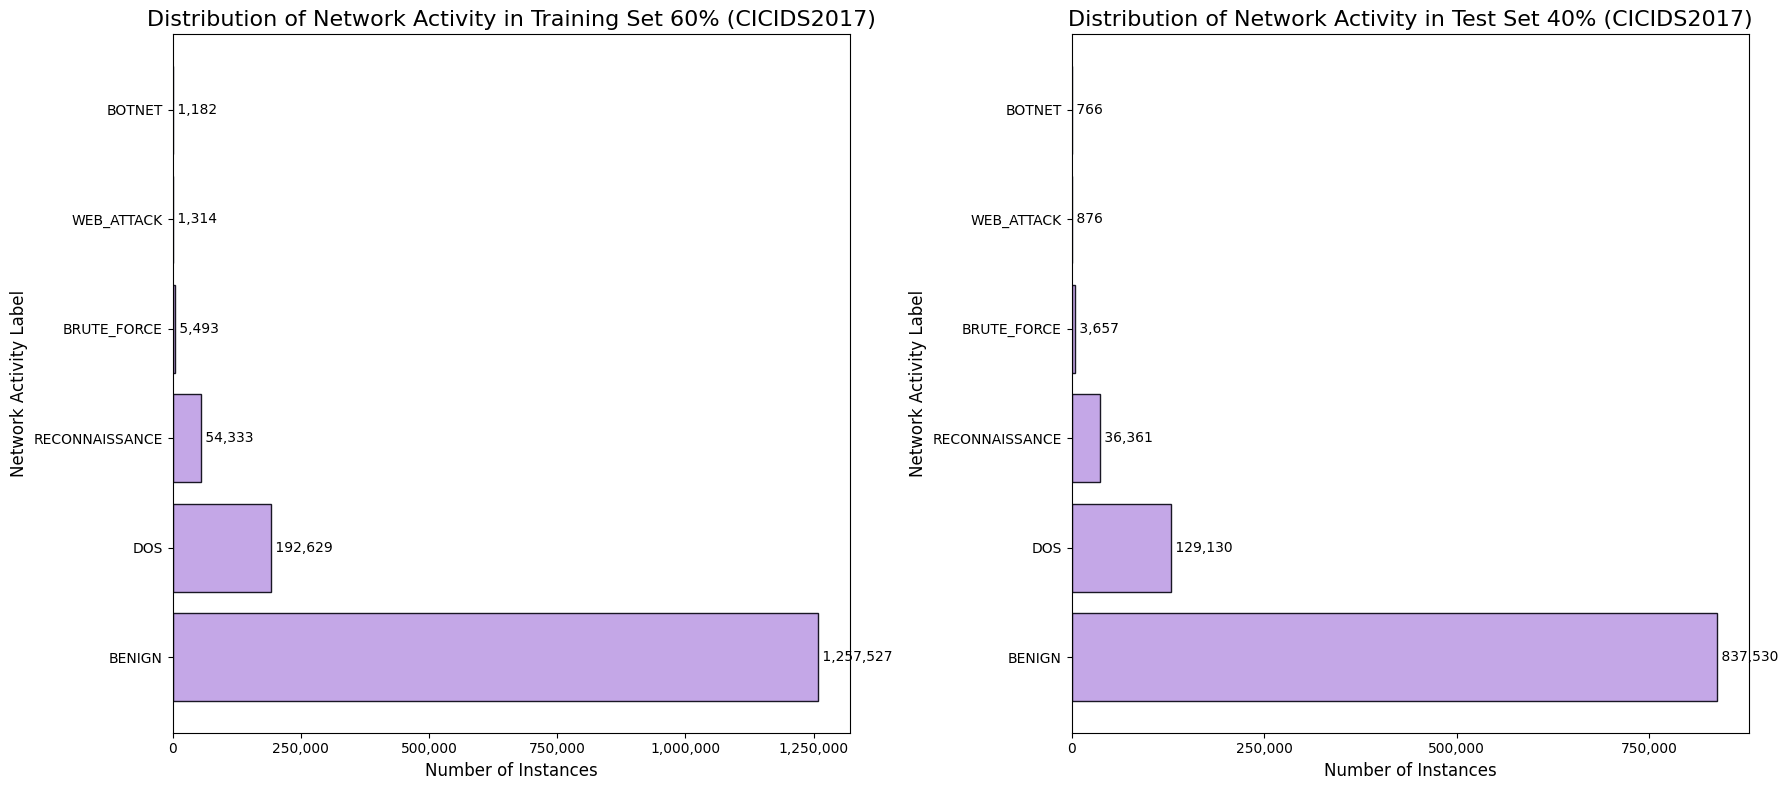

In [11]:
import matplotlib.pyplot as plt

# Analyze label distributions
train_label_distribution = y_train.value_counts()
test_label_distribution  = y_test.value_counts()

# Prepare x and y for training set
train_x_coords = train_label_distribution.index
train_y_coords = train_label_distribution.values

# Prepare x and y for test set
test_x_coords = test_label_distribution.index
test_y_coords = test_label_distribution.values

# Create subplots: 1 row, 2 columns
fig, (ax_train, ax_test) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# -----------------------------------
# Plot Training Set Distribution
# -----------------------------------
ax_train.barh(
    train_x_coords,
    train_y_coords,
    color=rp["iris"],      # Replace rp.iris with your preferred color or list of colors
    edgecolor=rp["base"]   # Same here if you have custom edges or replace with, for example, 'black'
)
# Add text at the end of each bar
for i, value in enumerate(train_y_coords):
    ax_train.text(
        value, 
        i, 
        f" {value:,}",
        va="center", 
        fontsize=10, 
        color="black"
    )

# Add chart details
ax_train.set_title(
    "Distribution of Network Activity in Training Set 60% (CICIDS2017)", 
    fontsize=16
)
ax_train.set_xlabel("Number of Instances", fontsize=12)
ax_train.set_ylabel("Network Activity Label", fontsize=12)

# Adjust x-tick limits and format labels (Training)
train_max = max(train_y_coords)
ax_train.set_xticks(
    range(0, train_max + 50_000, 250_000)
)
ax_train.set_xticklabels(
    [f"{x:,}" for x in range(0, train_max + 50_000, 250_000)],
    fontsize=10
)

# -----------------------------------
# Plot Test Set Distribution
# -----------------------------------
ax_test.barh(
    test_x_coords,
    test_y_coords,
    color=rp["iris"],      
    edgecolor=rp["base"]  
)
# Add text at the end of each bar
for i, value in enumerate(test_y_coords):
    ax_test.text(
        value, 
        i, 
        f" {value:,}",
        va="center", 
        fontsize=10, 
        color="black"
    )

# Add chart details
ax_test.set_title(
    "Distribution of Network Activity in Test Set 40% (CICIDS2017)", 
    fontsize=16
)
ax_test.set_xlabel("Number of Instances", fontsize=12)
ax_test.set_ylabel("Network Activity Label", fontsize=12)

# Adjust x-tick limits and format labels (Test)
test_max = max(test_y_coords)
ax_test.set_xticks(
    range(0, test_max + 50_000, 250_000)
)
ax_test.set_xticklabels(
    [f"{x:,}" for x in range(0, test_max + 50_000, 250_000)],
    fontsize=10
)

# Overall layout
plt.tight_layout()
plt.show()

# Training/Feature selection
To reduce the computation time we will first train a model without hyperparameter tuning and extract the most relevant features. This will reduce the dataset complexity for the hyperparemeter tuning. This idea is based on the finding of Kurniabudi et al, 2020 that the accuracy will not increase when using more the 22 feeatures and also the increase in completion time when using more features. 

The random forest classifier was choosen based on the performance described in Kurniabudi et al., “CICIDS-2017 Dataset Feature Analysis With Information Gain for Anomaly Detection.”
The default 100 estimators were halfed to 50 estimators the reduce computation time.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

TODO when using the whole dataset

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))
rf_all_report = classification_report(y_test, y_pred, digits=4, output_dict=True)

                precision    recall  f1-score   support

        BENIGN     0.9989    0.9992    0.9991    837530
        BOTNET     0.8610    0.7520    0.8028       766
   BRUTE_FORCE     0.9997    0.9986    0.9992      3657
           DOS     0.9988    0.9978    0.9983    129130
RECONNAISSANCE     0.9886    0.9881    0.9883     36361
    WEB_ATTACK     0.9894    0.9589    0.9739       876

      accuracy                         0.9984   1008320
     macro avg     0.9727    0.9491    0.9603   1008320
  weighted avg     0.9984    0.9984    0.9984   1008320



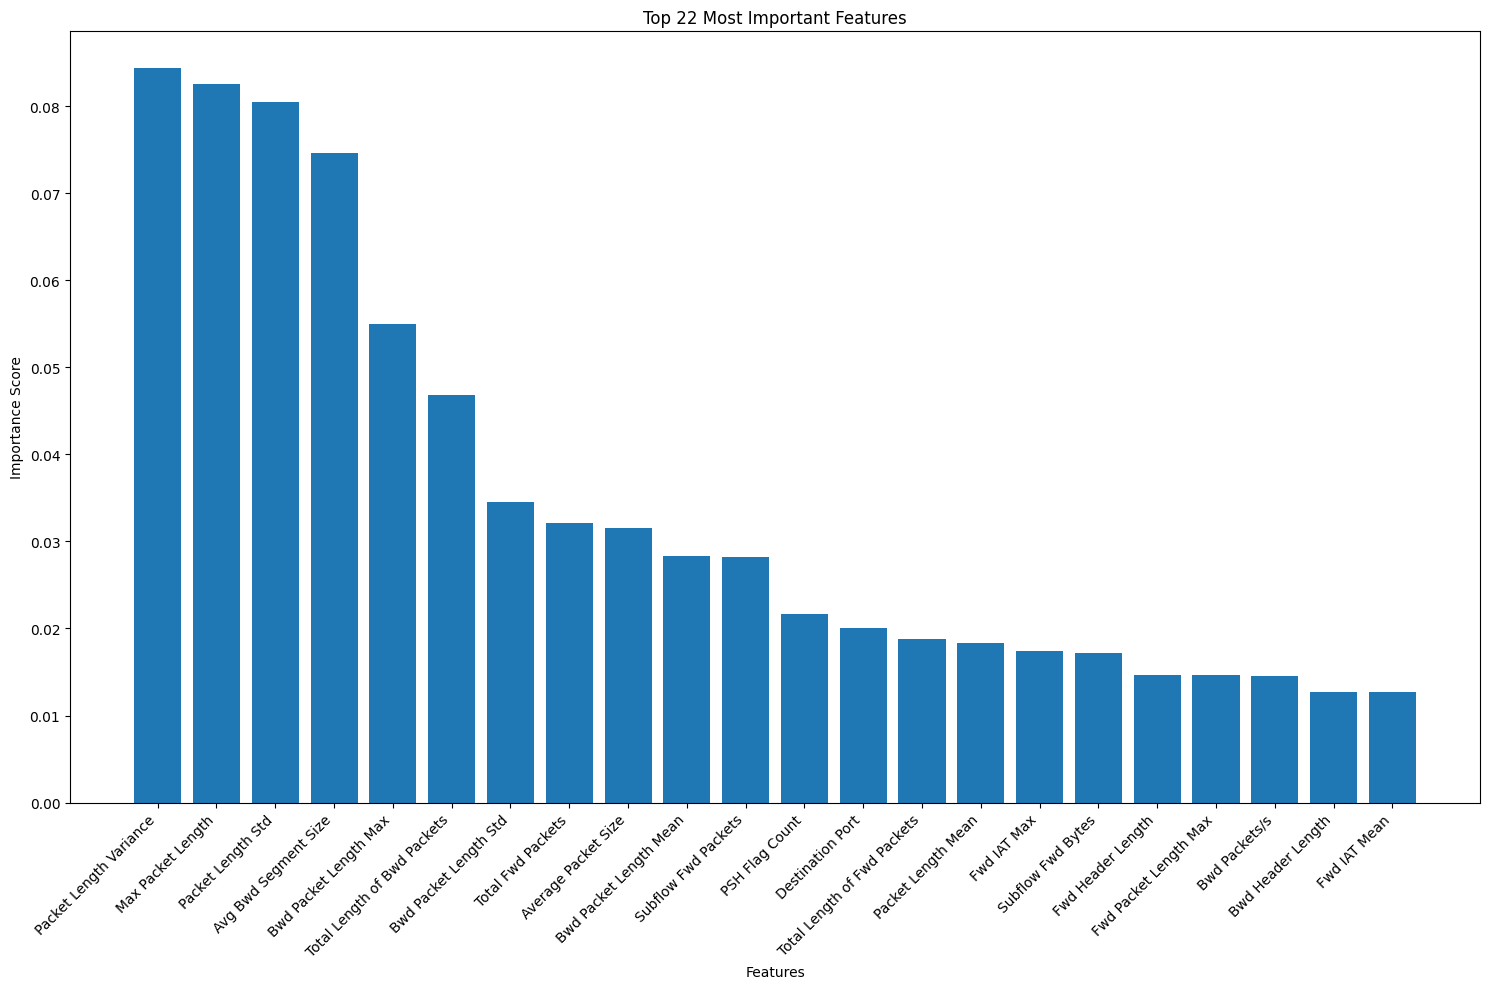


Top 22 Most Important Features:
                    feature  importance
     Packet Length Variance    0.084391
          Max Packet Length    0.082556
          Packet Length Std    0.080508
       Avg Bwd Segment Size    0.074671
      Bwd Packet Length Max    0.055014
Total Length of Bwd Packets    0.046863
      Bwd Packet Length Std    0.034578
          Total Fwd Packets    0.032108
        Average Packet Size    0.031503
     Bwd Packet Length Mean    0.028342
        Subflow Fwd Packets    0.028195
             PSH Flag Count    0.021686
           Destination Port    0.020067
Total Length of Fwd Packets    0.018844
         Packet Length Mean    0.018311
                Fwd IAT Max    0.017435
          Subflow Fwd Bytes    0.017151
          Fwd Header Length    0.014668
      Fwd Packet Length Max    0.014665
              Bwd Packets/s    0.014502
          Bwd Header Length    0.012724
               Fwd IAT Mean    0.012687


In [14]:
# Adjust here the number of features
num_of_features = 22

# get the feature importances from the model
importances = rf.feature_importances_
feature_names = X.columns

# contruct featuere importance dataframe and sort it descending
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Create plot
plt.figure(figsize=(15, 10))
plt.bar(range(num_of_features), feature_importance['importance'][:num_of_features])
plt.xticks(range(num_of_features), feature_importance['feature'][:num_of_features], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title(f'Top {num_of_features} Most Important Features')
plt.tight_layout()
plt.show()

print(f"\nTop {num_of_features} Most Important Features:")
print(feature_importance.head(num_of_features).to_string(index=False))

The feature importances are pretty similiar to Kurniabudi et al., 2020 but differences are possibly due to slighty different calculation methods.  Sci kitlearn uses feature importance based on mean decrease in impurity and Kurniabudi et al., 2020 uses informtion gain. 
In addition in Kurniabudi et al., 2020 were only 20% of the dataset used which can lead to differences

In [15]:
# Get top features based on importance
top_features = feature_importance['feature'][:num_of_features]

# Filter the original DataFrame to retain only the top features
X_top = X[top_features] 

# not needed but for naming purposes  
y_top = y

In [16]:
# make new train test splits only using the top features
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.3, random_state=42)

TODO 
Check differences to rf with all features

In [17]:
rf_top = RandomForestClassifier(n_estimators=50, random_state=42)
rf_top.fit(X_train_top, y_train_top)
y_pred_top = rf_top.predict(X_test_top)
print(classification_report(y_test_top, y_pred_top, digits=4))
rf_top_report = classification_report(y_test_top, y_pred_top, digits=4,output_dict=True)

                precision    recall  f1-score   support

        BENIGN     0.9985    0.9988    0.9987    628081
        BOTNET     0.7108    0.5590    0.6259       576
   BRUTE_FORCE     0.9920    0.9902    0.9911      2769
           DOS     0.9971    0.9960    0.9965     96787
RECONNAISSANCE     0.9891    0.9909    0.9900     27358
    WEB_ATTACK     0.9646    0.9372    0.9507       669

      accuracy                         0.9978    756240
     macro avg     0.9420    0.9120    0.9255    756240
  weighted avg     0.9977    0.9978    0.9977    756240



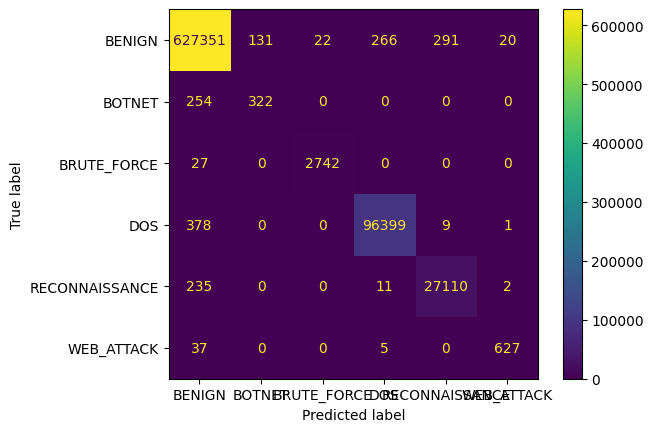

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_top, y_pred_top)

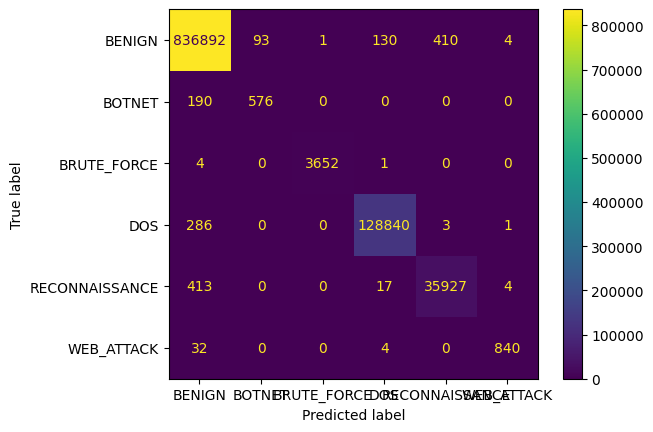

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [20]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# parameters to use in the grid search
params = {
    'max_depth': range(10, 20),
    'n_estimators': [10, 50, 100, 150, 200],
}

rf_grid = HalvingGridSearchCV(
    rf_top,
    params,
    cv=5,
    scoring='accuracy',
    verbose=1,
    return_train_score=True,
    n_jobs=-1
)

rf_grid.fit(X_train_top, y_train_top)

print("\nGrid Search Best Params:", rf_grid.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 65354
max_resources_: 1764558
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 65354
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 1
n_candidates: 17
n_resources: 196062
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 2
n_candidates: 6
n_resources: 588186
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 1764558
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Grid Search Best Params: {'max_depth': 19, 'n_estimators': 200}


In [21]:
# get the best model found in the grid search
rf_best_model = rf_grid.best_estimator_

# use it to predict on the test data
y_pred_top = rf_best_model.predict(X_test_top)

print(classification_report(y_test_top, y_pred_top,digits=4))
rf_best_report = classification_report(y_test_top, y_pred_top, digits=4, output_dict=True)

                precision    recall  f1-score   support

        BENIGN     0.9980    0.9991    0.9985    628081
        BOTNET     0.8521    0.4601    0.5975       576
   BRUTE_FORCE     0.9939    0.9949    0.9944      2769
           DOS     0.9980    0.9959    0.9970     96787
RECONNAISSANCE     0.9891    0.9993    0.9942     27358
    WEB_ATTACK     0.8359    0.1599    0.2685       669

      accuracy                         0.9975    756240
     macro avg     0.9445    0.7682    0.8084    756240
  weighted avg     0.9974    0.9975    0.9972    756240



In [22]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

le = LabelEncoder()
y_train_top_encoded = le.fit_transform(y_train_top)
y_test_top_encoded = le.transform(y_test_top)

xgb_top = XGBClassifier(n_estimators=50, random_state=42)
xgb_top.fit(X_train_top, y_train_top_encoded)

y_pred_top_xgb = xgb_top.predict(X_test_top)

y_pred_top_decoded = le.inverse_transform(y_pred_top_xgb)

print(classification_report(y_test_top, y_pred_top_decoded, digits=4))
xgb_top_report = classification_report(y_test_top, y_pred_top_decoded, digits=4,output_dict=True)

                precision    recall  f1-score   support

        BENIGN     0.9978    0.9991    0.9984    628081
        BOTNET     1.0000    0.3958    0.5672       576
   BRUTE_FORCE     0.9935    0.9949    0.9942      2769
           DOS     0.9975    0.9949    0.9962     96787
RECONNAISSANCE     0.9891    0.9993    0.9942     27358
    WEB_ATTACK     0.8148    0.1644    0.2736       669

      accuracy                         0.9974    756240
     macro avg     0.9654    0.7581    0.8040    756240
  weighted avg     0.9972    0.9974    0.9970    756240



In [23]:
# Parameters for grid search
params = {
    'max_depth': range(7, 20),
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.3, 0.1, 0.01]
}

xgb_grid = HalvingGridSearchCV(
    estimator=xgb_top,
    param_grid=params,
    cv=5,
    scoring='accuracy',
    verbose=1,
    return_train_score=True,
    n_jobs=-1
)

xgb_grid.fit(X_train_top, y_train_top_encoded)

print("\nGrid Search Best Params:", xgb_grid.best_params_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 21784
max_resources_: 1764558
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 117
n_resources: 21784
Fitting 5 folds for each of 117 candidates, totalling 585 fits
----------
iter: 1
n_candidates: 39
n_resources: 65352
Fitting 5 folds for each of 39 candidates, totalling 195 fits
----------
iter: 2
n_candidates: 13
n_resources: 196056
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 3
n_candidates: 5
n_resources: 588168
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 1764504
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Grid Search Best Params: {'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 100}


In [24]:
xgb_best_model = xgb_grid.best_estimator_

y_pred_top_xgb = xgb_best_model.predict(X_test_top)


y_pred_top_decoded = le.inverse_transform(y_pred_top_xgb)
y_test_top_decoded = le.inverse_transform(y_test_top_encoded)

print(classification_report(y_test_top, y_pred_top_decoded, digits=4))
xgb_best_report = classification_report(y_test_top, y_pred_top_decoded, digits=4, output_dict=True)

                precision    recall  f1-score   support

        BENIGN     0.9978    0.9991    0.9985    628081
        BOTNET     0.9346    0.4219    0.5813       576
   BRUTE_FORCE     0.9939    0.9946    0.9942      2769
           DOS     0.9978    0.9952    0.9965     96787
RECONNAISSANCE     0.9890    0.9993    0.9941     27358
    WEB_ATTACK     0.8258    0.1629    0.2722       669

      accuracy                         0.9974    756240
     macro avg     0.9565    0.7622    0.8061    756240
  weighted avg     0.9973    0.9974    0.9971    756240



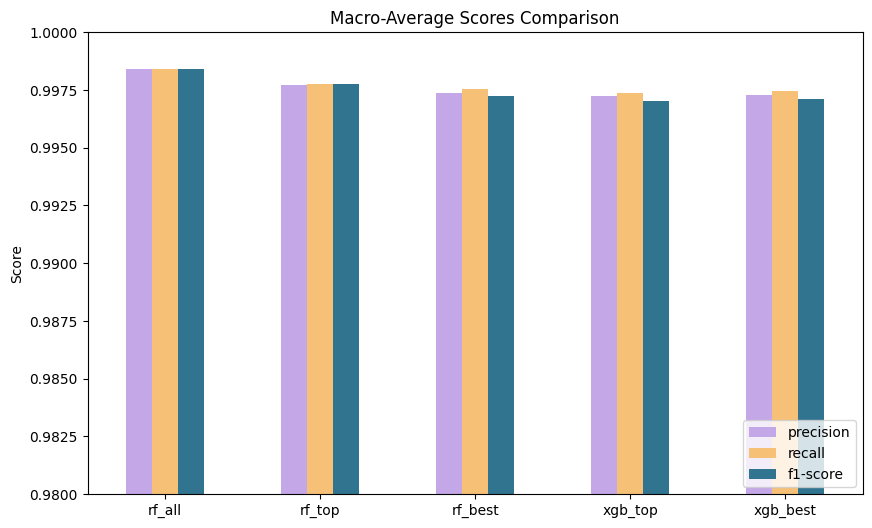

In [25]:
# put all reports in a list
reports = [rf_all_report, rf_top_report, rf_best_report, xgb_top_report, xgb_best_report]

model_names = ["rf_all", "rf_top", "rf_best", "xgb_top", "xgb_best"]
# Initialize an empty DataFrame
comparison_df = pd.DataFrame(
    columns=["precision", "recall", "f1-score"], 
    index=model_names
)

for name, report in zip(model_names, reports):
    # 'macro avg' is a key in the dictionary
    macro_avg = report["weighted avg"]
    comparison_df.loc[name, "precision"] = macro_avg["precision"]
    comparison_df.loc[name, "recall"]    = macro_avg["recall"]
    comparison_df.loc[name, "f1-score"]  = macro_avg["f1-score"]



colors = [rp["iris"], rp["gold"], rp["pine"]]

comparison_df.plot.bar(
    figsize=(10, 6), 
    color=colors
)
plt.title("Macro-Average Scores Comparison")
plt.ylabel("Score")
plt.ylim([0.98, 1])
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

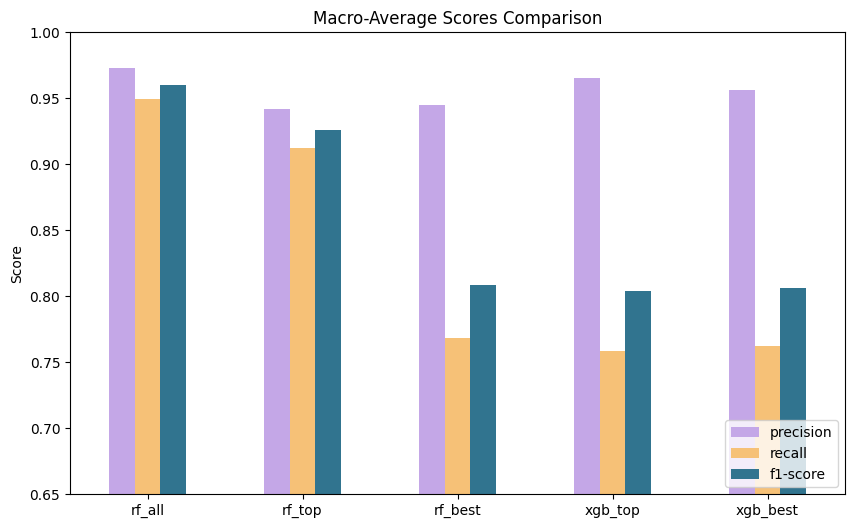

In [26]:
# put all reports in a list
reports = [rf_all_report, rf_top_report, rf_best_report, xgb_top_report, xgb_best_report]

model_names = ["rf_all", "rf_top", "rf_best", "xgb_top", "xgb_best"]
# Initialize an empty DataFrame
comparison_df = pd.DataFrame(
    columns=["precision", "recall", "f1-score"], 
    index=model_names
)

for name, report in zip(model_names, reports):
    # 'macro avg' is a key in the dictionary
    macro_avg = report["macro avg"]
    comparison_df.loc[name, "precision"] = macro_avg["precision"]
    comparison_df.loc[name, "recall"]    = macro_avg["recall"]
    comparison_df.loc[name, "f1-score"]  = macro_avg["f1-score"]



colors = [rp["iris"], rp["gold"], rp["pine"]]

comparison_df.plot.bar(
    figsize=(10, 6), 
    color=colors
)
plt.title("Macro-Average Scores Comparison")
plt.ylabel("Score")
plt.ylim([0.65, 1])
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Citations
Kurniabudi, Deris Stiawan, Darmawijoyo, Mohd Yazid Bin Idris, Alwi M. Bamhdi, and Rahmat Budiarto. “CICIDS-2017 Dataset Feature Analysis With Information Gain for Anomaly Detection.” IEEE Access 8 (2020): 132911–21. https://doi.org/10.1109/ACCESS.2020.3009843.